# Pre-Requisites

In [2]:
from datetime import datetime
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

'06Dec2021 22:43'

## Importing the Covsirphy Package

We will be needing the Covsirphy package for this notebook. To install the covsirphy package use the command:

`pip install covsirphy==2.22.2`

We will also be needing the `openpyxl` package which can be installed using the following command:

`pip install openpyxl`

In [3]:
import covsirphy as cs
cs.__version__

D:\DRBCMSocialMedia\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'2.22.2'

# Importing Other Essential Modules

In [5]:
from collections import defaultdict
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import functools
from IPython.display import display, Markdown
import math
import os
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import numpy as np
import pandas as pd
import dask.dataframe as dd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
import scipy as sci
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import sympy as sym
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch
import torchvision

# Plot Configuration

In [ ]:
# Ramdam
np.random.seed(123)
os.environ["PYTHONHASHSEED"] = "123"
# Matplotlib
plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.0
plt.rcParams["figure.figsize"] = (9, 6)
# Pandas
pd.set_option("display.max_colwidth", 1000)

# Loading Data

In [10]:
# Create instance of covsirphy.DataLoader class
data_loader = cs.DataLoader(directory="kaggle/input")
# Retrieve the dataset of the number of COVID-19 cases
# Kaggle platform: covid19dh.csv will be saved in /output/kaggle/working/input
# Local env: covid19dh.csv will be saved in kaggle/input
jhu_data = data_loader.jhu()

Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan
Retrieving datasets from COVID-19 Data Hub https://covid19datahub.io/
	Please set verbose=2 to see the detailed citation list.
Retrieving datasets from Our World In Data https://github.com/owid/covid-19-data/
Retrieving datasets from COVID-19 Open Data by Google Cloud Platform https://github.com/GoogleCloudPlatform/covid-19-open-data


# Exploring the Data

In [11]:
jhu_data.cleaned().tail()

,Date,ISO3,Country,Province,Confirmed,Infected,Fatal,Recovered,Population
1006779,2021-12-01,ZWE,Zimbabwe,-,135337,47636,4707,82994,14439018
1006780,2021-12-02,ZWE,Zimbabwe,-,136379,48678,4707,82994,14439018
1006781,2021-12-03,ZWE,Zimbabwe,-,137441,49739,4708,82994,14439018
1006782,2021-12-04,ZWE,Zimbabwe,-,138523,50820,4709,82994,14439018
1006783,2021-12-05,ZWE,Zimbabwe,-,139046,51342,4710,82994,14439018


In [12]:
jhu_data.subset("Japan", province=None).tail()

,Date,Confirmed,Infected,Fatal,Recovered,Susceptible
665,2021-12-02,1726436,326,18362,1707748,124802664
666,2021-12-03,1726581,325,18364,1707892,124802519
667,2021-12-04,1726711,290,18364,1708057,124802389
668,2021-12-05,1726825,276,18364,1708185,124802275
669,2021-12-06,1726895,345,18365,1708185,124802205


In [13]:
df = jhu_data.cleaned()
jhu_first_date, jhu_last_date = df["Date"].min(), df["Date"].max()
jhu_elapsed = (jhu_last_date - jhu_first_date).days
print(f"{jhu_elapsed} days have passed from the date of the first record.")

705 days have passed from the date of the first record.


# Understanding Amount of Time Spent Outside

In [14]:
pyramid_data = data_loader.pyramid()

In [15]:
_period_of_life_list = [
    "nursery", "nursery school", "elementary school", "middle school",
    "high school", "university/work", "work", "work", "work", "work",
    "retired", "retired", "retired"
]
df = pd.DataFrame(
    {
        "Age_first": [0, 3, 6, 11, 14, 19, 26, 36, 46, 56, 66, 76, 86],
        "Age_last": [2, 5, 10, 13, 18, 25, 35, 45, 55, 65, 75, 85, 95],
        "Period_of_life": _period_of_life_list,
        "Days": [3, 5, 6, 6, 7, 7, 6, 5, 5, 5, 4, 3, 2]
    }
)
# Adjustment by author
df["Types"] = df["Period_of_life"].replace(
    {
        "nursery": "school",
        "nursery school": "school",
        "elementary school": "school",
        "middle school": "school",
        "high school": "school",
        "university/work": "school/work"
    }
)
df["School"] = df[["Types", "Days"]].apply(lambda x: x[1] if "school" in x[0] else 0, axis=1)
df["Office"] = df[["Types", "Days"]].apply(lambda x: x[1] if "work" in x[0] else 0, axis=1)
df["Others"] = df["Days"] - df[["School", "Office"]].sum(axis=1)
df.loc[df["Others"] < 0, "Others"] = 0
df.loc[df.index[1:5], "School"] -= 1
df.loc[df.index[1:5], "Others"] += 1
df.loc[df.index[5], ["School", "Office", "Others"]] = [3, 3, 1]
df[["School", "Office", "Others"]] = df[["Days", "School", "Office", "Others"]].apply(
    lambda x: x[1:] / sum(x[1:]) * x[0], axis=1
).astype(np.int64)
df.loc[df.index[6:10], "Others"] += 1
df = df.drop(["Days", "Types"], axis=1)
# Show dataset
_out_df = df.copy()
_out_df

,Age_first,Age_last,Period_of_life,School,Office,Others
0,0,2,nursery,3,0,0
1,3,5,nursery school,4,0,1
2,6,10,elementary school,5,0,1
3,11,13,middle school,5,0,1
4,14,18,high school,6,0,1
5,19,25,university/work,3,3,1
6,26,35,work,0,6,1
7,36,45,work,0,5,1
8,46,55,work,0,5,1
9,56,65,work,0,5,1


# Time Spent Outside Statistics of a Country

In [16]:
def go_out(country, pyramid_data=pyramid_data):
    """
    Return the estimated number of days people usually go out.
    Args:
        country (str): coutry name
        pyramid_data (covsirphy.PopulationPyramidData): pyramid dataset
    
    Returns:
        pandas.DataFrame
    """
    p_df = pyramid_data.subset(country)
    p_df["Cumsum"] = p_df["Population"].cumsum()
    df = pd.merge(_out_df, p_df, left_on="Age_last", right_on="Age", how="left")
    df["Population"] = df["Cumsum"].diff()
    df.loc[df.index[0], "Population"] = df.loc[df.index[0], "Cumsum"]
    df["Population"] = df["Population"].astype(np.int64)
    df["Portion"] = df["Population"] / df["Population"].sum()
    return df.drop(["Per_total", "Cumsum"], axis=1)

go_out("Italy")

,Age_first,Age_last,Period_of_life,School,Office,Others,Age,Population,Portion
0,0,2,nursery,3,0,0,2,1373871,0.025722
1,3,5,nursery school,4,0,1,5,1441955,0.026997
2,6,10,elementary school,5,0,1,10,2667055,0.049933
3,11,13,middle school,5,0,1,13,1688673,0.031616
4,14,18,high school,6,0,1,18,2829215,0.052969
5,19,25,university/work,3,3,1,25,4087599,0.076529
6,26,35,work,0,6,1,35,6521421,0.122096
7,36,45,work,0,5,1,45,7940871,0.148671
8,46,55,work,0,5,1,55,9560703,0.178998
9,56,65,work,0,5,1,65,8261046,0.154666


In [ ]:
go_out("Japan")

# Understanding the Scenario in Italy

In [17]:
data_cols = ["Infected", "Fatal", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]

In [18]:
total_df = jhu_data.total()
total_df = total_df.loc[total_df.index <= jhu_last_date, :]
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2021-12-02,264765366,119744406,5267892,139753068,0.019896,0.527837,0.036325
2021-12-03,263143427,120497960,5075030,137570437,0.019286,0.522796,0.035578
2021-12-04,263593164,120907099,5080063,137606002,0.019272,0.522039,0.035603
2021-12-05,253528056,110954293,4941363,137632400,0.019490,0.542869,0.034658
2021-12-06,72128940,17941344,1242757,52944839,0.017230,0.734030,0.022934


# Cases Over Time

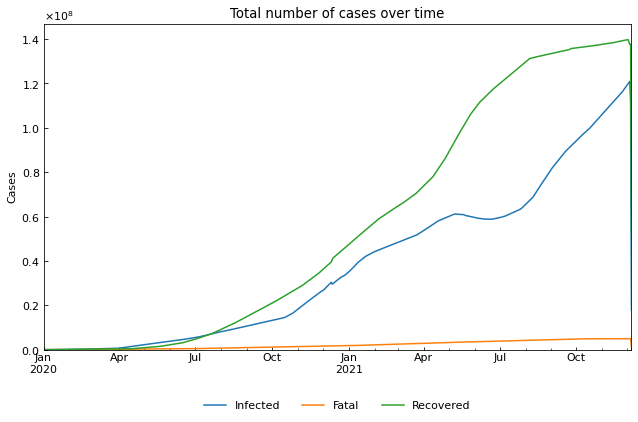

In [20]:
cs.line_plot(total_df[data_cols], "Total number of cases over time")

# Global Rate Over Time

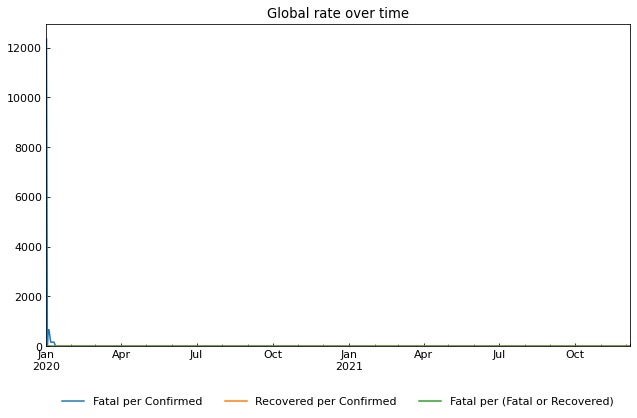

In [21]:
cs.line_plot(total_df[rate_cols], "Global rate over time", ylabel="", math_scale=False)

# KDE Plot

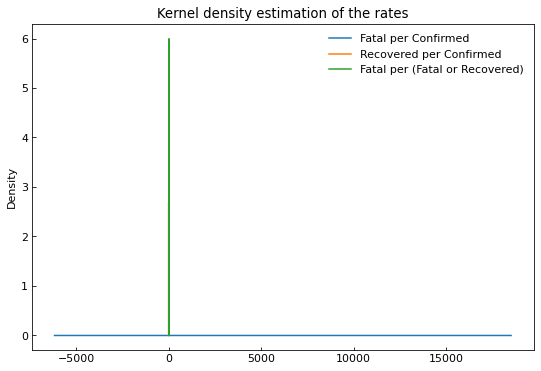

In [22]:
total_df[rate_cols].plot.kde()
plt.title("Kernel density estimation of the rates")
plt.show()

# Generating Statistics Using Sample SIR-F Model

In [6]:
print(cs.SIRD.NAME)
# Example parameter values
pprint(cs.SIRD.EXAMPLE, compact=True)

SIR-D
{'param_dict': {'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal': 0,
             'Infected': 1000,
             'Recovered': 0,
             'Susceptible': 999000}}


In [7]:
print(cs.SIRF.NAME)
# Example parameter values
pprint(cs.SIRF.EXAMPLE, compact=True)

SIR-F
{'param_dict': {'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075, 'theta': 0.002},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal': 0,
             'Infected': 1000,
             'Recovered': 0,
             'Susceptible': 999000}}


In [9]:
# Set tau value and start date of records
# For explanation, the start date will be 01Jan2020
# This is not based on actual data
example_data = cs.ExampleData(tau=1440, start_date="01Jan2020")
# No records has been registered
example_data.cleaned()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered


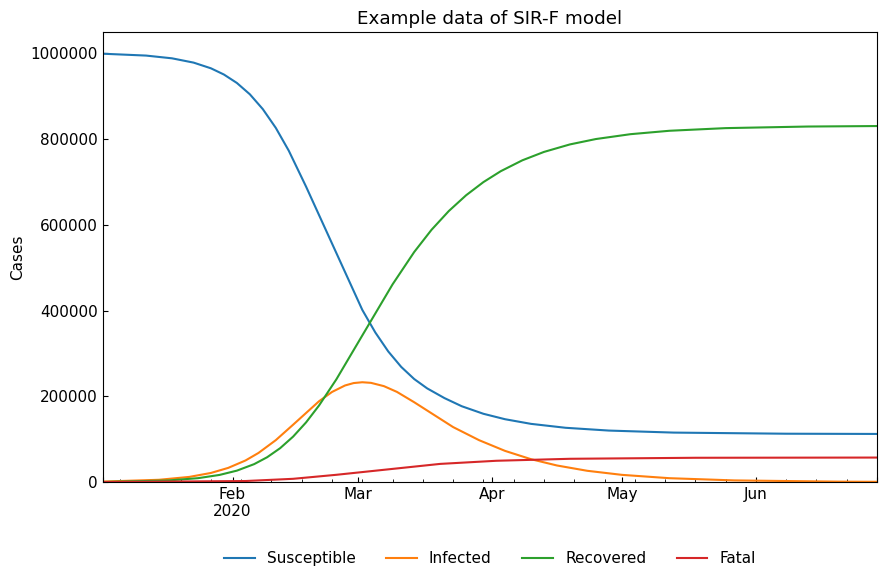

In [10]:
model = cs.SIRF
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)

In [11]:
eg_r0 = model(model.EXAMPLE["population"], **model.EXAMPLE["param_dict"]).calc_r0()
df = example_data.specialized(model, **area)
x_max = df.loc[df["Infected"].idxmax(), "Susceptible"] / cs.SIR.EXAMPLE["population"]
(x_max, 1/eg_r0)

(0.401442, 0.4)

# S-R Trend Analysis in Italy

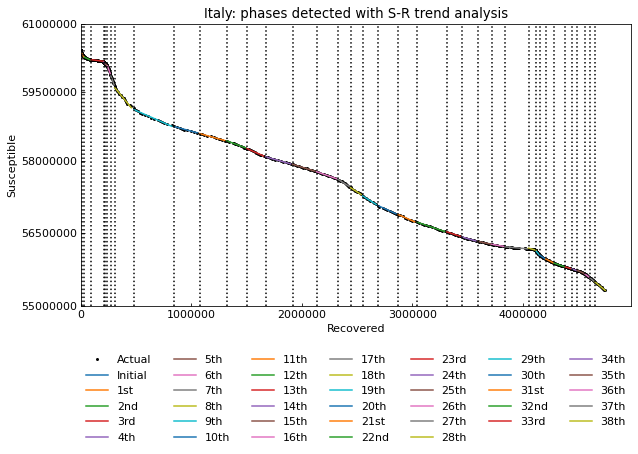

In [29]:
ita_scenario = cs.Scenario(country="Italy")
ita_scenario.register(jhu_data)
_ = ita_scenario.trend()

# Italy Scenario Analysis

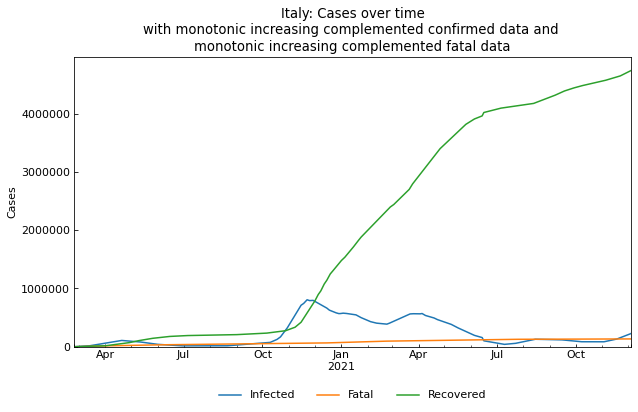

,Date,Infected,Fatal,Recovered
646,2021-12-01,199783,133931,4709906
647,2021-12-02,208871,134003,4717556
648,2021-12-03,216154,134077,4727214
649,2021-12-04,223718,134152,4736202
650,2021-12-05,232000,134195,4742887


In [30]:
ita_scenario.records().tail()

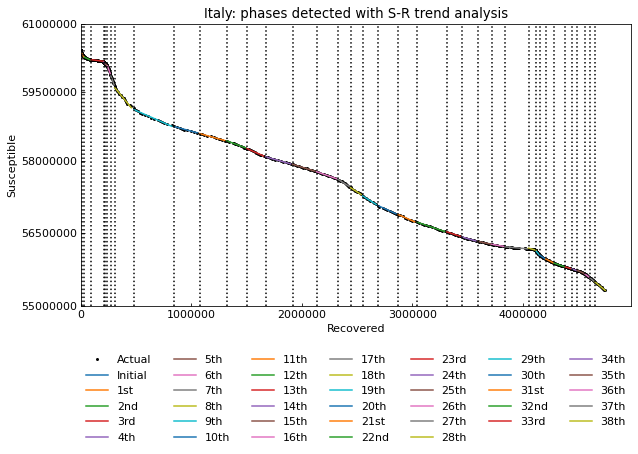

In [31]:
_ = ita_scenario.trend()

In [32]:
ita_scenario.summary()

,Type,Start,End,Population
0th,Past,24Feb2020,22Mar2020,60421760
1st,Past,23Mar2020,10Apr2020,60421760
2nd,Past,11Apr2020,05May2020,60421760
3rd,Past,06May2020,28Aug2020,60421760
4th,Past,29Aug2020,25Sep2020,60421760
5th,Past,26Sep2020,12Oct2020,60421760
6th,Past,13Oct2020,26Oct2020,60421760
7th,Past,27Oct2020,03Nov2020,60421760
8th,Past,04Nov2020,17Nov2020,60421760
9th,Past,18Nov2020,02Dec2020,60421760


In [33]:
ita_scenario.estimate(cs.SIRF, timeout=120)


<SIR-F model: parameter estimation>
Running optimization with 16 CPUs...
Completed optimization. Total: 0 min 32 sec


In [34]:
ita_scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
0th,Past,24Feb2020,22Mar2020,60421760,SIR-F,7.66,0.030976,0.008280,0.268516,0.025700,1440,0.031,120,3,38,0.382743,279,0 min 16 sec
1st,Past,23Mar2020,10Apr2020,60421760,SIR-F,2.68,0.018942,0.009642,0.071744,0.016585,1440,0.019,103,13,60,0.058063,111,0 min 6 sec
2nd,Past,11Apr2020,05May2020,60421760,SIR-F,1.11,0.064063,0.002761,0.027979,0.020900,1440,0.064,362,35,47,0.033614,196,0 min 11 sec
3rd,Past,06May2020,28Aug2020,60421760,SIR-F,0.37,0.109315,0.000647,0.014355,0.034009,1440,0.109,1544,69,29,0.234294,93,0 min 5 sec
4th,Past,29Aug2020,25Sep2020,60421760,SIR-F,2.82,0.001056,0.000452,0.044569,0.015364,1440,0.001,2211,22,65,0.024925,110,0 min 6 sec
5th,Past,26Sep2020,12Oct2020,60421760,SIR-F,2.76,0.013861,0.000327,0.044441,0.015562,1440,0.014,3058,22,64,0.030292,77,0 min 4 sec
6th,Past,13Oct2020,26Oct2020,60421760,SIR-F,6.82,0.003059,0.000493,0.091257,0.012857,1440,0.003,2029,10,77,0.014677,43,0 min 2 sec
7th,Past,27Oct2020,03Nov2020,60421760,SIR-F,8.00,0.000177,0.000759,0.087592,0.010182,1440,0.000,1317,11,98,0.012532,159,0 min 9 sec
8th,Past,04Nov2020,17Nov2020,60421760,SIR-F,3.27,0.000650,0.000790,0.064386,0.018868,1440,0.001,1265,15,52,0.020681,454,0 min 24 sec
9th,Past,18Nov2020,02Dec2020,60421760,SIR-F,1.19,0.000093,0.000945,0.038085,0.031019,1440,0.000,1057,26,32,0.021232,130,0 min 7 sec


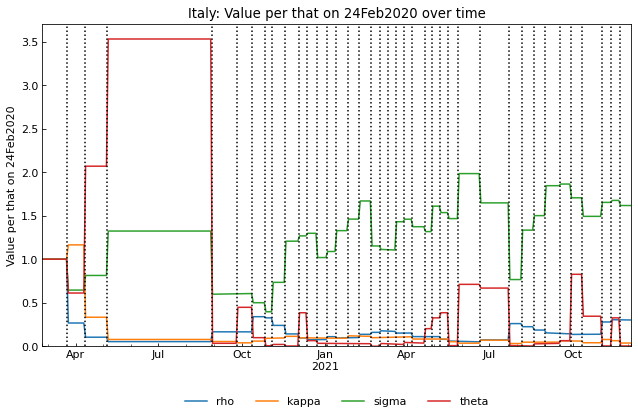

In [35]:
_ = ita_scenario.history_rate()

In [36]:
rho_before = cs.SIRF.EXAMPLE["param_dict"]["rho"]
rho_before

0.2

In [39]:
eg_out_df = go_out("Italy")
eg_out_df

,Age_first,Age_last,Period_of_life,School,Office,Others,Age,Population,Portion
0,0,2,nursery,3,0,0,2,1373871,0.025722
1,3,5,nursery school,4,0,1,5,1441955,0.026997
2,6,10,elementary school,5,0,1,10,2667055,0.049933
3,11,13,middle school,5,0,1,13,1688673,0.031616
4,14,18,high school,6,0,1,18,2829215,0.052969
5,19,25,university/work,3,3,1,25,4087599,0.076529
6,26,35,work,0,6,1,35,6521421,0.122096
7,36,45,work,0,5,1,45,7940871,0.148671
8,46,55,work,0,5,1,55,9560703,0.178998
9,56,65,work,0,5,1,65,8261046,0.154666


In [40]:
ita_scenario.get("Start", name="Main", phase="3rd")

'06May2020'

In [42]:
ita_out_df = go_out("Italy")
ita_out_df

,Age_first,Age_last,Period_of_life,School,Office,Others,Age,Population,Portion
0,0,2,nursery,3,0,0,2,1373871,0.025722
1,3,5,nursery school,4,0,1,5,1441955,0.026997
2,6,10,elementary school,5,0,1,10,2667055,0.049933
3,11,13,middle school,5,0,1,13,1688673,0.031616
4,14,18,high school,6,0,1,18,2829215,0.052969
5,19,25,university/work,3,3,1,25,4087599,0.076529
6,26,35,work,0,6,1,35,6521421,0.122096
7,36,45,work,0,5,1,45,7940871,0.148671
8,46,55,work,0,5,1,55,9560703,0.178998
9,56,65,work,0,5,1,65,8261046,0.154666


In [43]:
df = ita_out_df.copy()
gs_before = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
print(f"{round(gs_before, 1)} days in a week susceptible people go out.")

5.8 days in a week susceptible people go out.


In [44]:
sigma_before = ita_scenario.get("sigma", name="Main", phase="3rd")
kappa_before = ita_scenario.get("kappa", name="Main", phase="3rd")
(sigma_before, kappa_before)

(0.03400918093770855, 0.0006473234541727906)

# Medicine

In [45]:
sigma_med = ita_scenario.get("tau", name="Main", phase="3rd") * (25 / 53) / ((10 + 18) * 1440)
kappa_med = ita_scenario.get("tau", name="Main", phase="3rd") * (7 / 53) / ((10 + 18) * 1440)
(sigma_med, kappa_med)

(0.016846361185983826, 0.0047169811320754715)

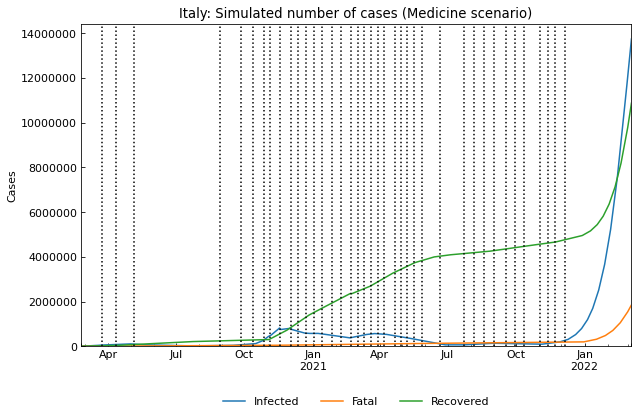

,Date,Infected,Fatal,Recovered
734,2022-02-27 00:00:00,11718073,1486319,9580827
735,2022-02-28 00:00:00,12056985,1542463,9781088
736,2022-03-01 00:00:00,12395736,1600206,9987058
737,2022-03-02 00:00:00,12733653,1659546,10198730
738,2022-03-03 00:00:00,13070053,1720478,10416082
739,2022-03-04 00:00:00,13404243,1782992,10639083
740,2022-03-05 00:00:00,13735520,1847076,10867691


In [46]:
ita_scenario.clear(name="Medicine")
ita_scenario.add(days=90, name="Medicine", kappa=kappa_med, sigma=sigma_med)
ita_scenario.simulate(name="Medicine").tail(7).style.background_gradient(axis=0,cmap='YlOrRd')

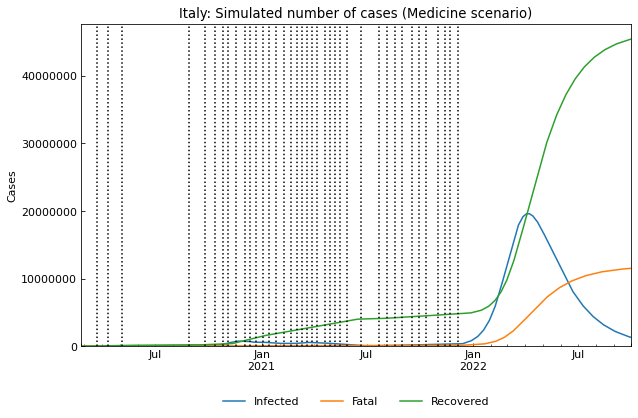

In [47]:
ita_scenario.clear(name="Medicine")
ita_scenario.add(days=300, name="Medicine", kappa=kappa_med, sigma=sigma_med)
_ = ita_scenario.simulate(name="Medicine")

# Effect of School Closedown

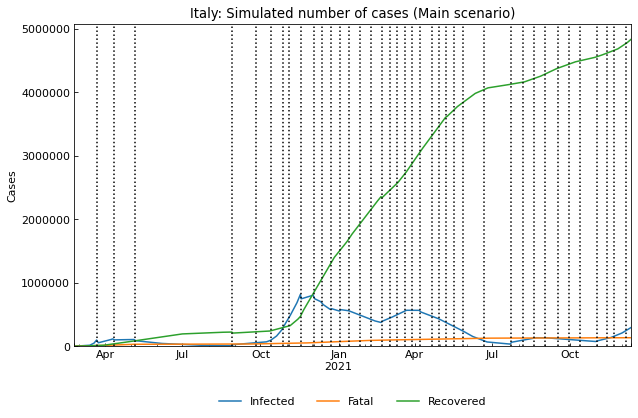

,Date,Infected,Fatal,Recovered
651,2021-12-06 00:00:00,246450,134166,4768984
652,2021-12-07 00:00:00,254531,134245,4779390
653,2021-12-08 00:00:00,262870,134326,4790136
654,2021-12-09 00:00:00,271475,134410,4801235
655,2021-12-10 00:00:00,280354,134496,4812697
656,2021-12-11 00:00:00,289515,134586,4824533
657,2021-12-12 00:00:00,298968,134678,4836756


In [48]:
ita_scenario.clear()
ita_scenario.add(days=7)
ita_scenario.simulate().tail(7).style.background_gradient(axis=0,cmap='YlOrRd')

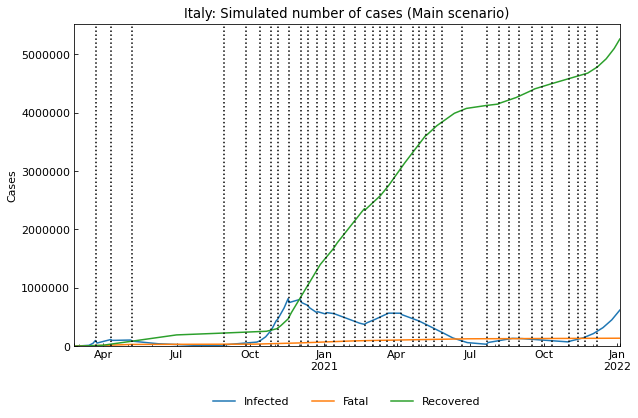

,Date,Infected,Fatal,Recovered
674,2021-12-29 00:00:00,513421,136796,5117105
675,2021-12-30 00:00:00,529810,136960,5138775
676,2021-12-31 00:00:00,546692,137129,5161134
677,2022-01-01 00:00:00,564083,137303,5184206
678,2022-01-02 00:00:00,581994,137483,5208010
679,2022-01-03 00:00:00,600440,137668,5232570
680,2022-01-04 00:00:00,619435,137859,5257908


In [49]:
ita_scenario.clear()
ita_scenario.add(days=30)
ita_scenario.simulate().tail(7).style.background_gradient(axis=0,cmap='YlOrRd')


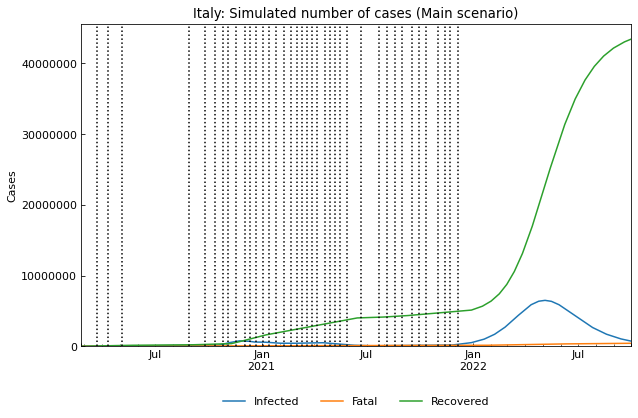

In [50]:
ita_scenario.clear()
ita_scenario.add(days=300)
_ = ita_scenario.simulate()